<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/LazyPredict%20Stacking%20and%20Combinations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lazypredict
!pip install optuna

In [ ]:
# !sudo apt-get install build-essential swig
# !pip install auto-sklearn==0.11.1

In [ ]:
# from autosklearn.regression import AutoSklearnRegressor

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

In [190]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [191]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [192]:
train.shape, test.shape

((91598, 20), (132900, 20))

In [193]:
train.head()

,id,Moons,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18
0,0xfdd687137acd15f5,0,0.00,1.00,0.25,0.75,0.00,0.25,0.50,0.25,0.25,0.25,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0.75
1,0x3c2877496bd2e323,0,0.00,0.00,0.25,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
2,0x1cf2ee1bf0af428d,0,0.75,0.75,0.00,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.75,1.00
3,0xe6c2816af56514fa,0,0.75,0.50,0.25,0.25,0.75,0.25,0.25,0.50,0.50,0.50,0.25,0.50,0.50,0.00,0.00,0.00,0.75,0.75
4,0xac048d969d0d3b9,0,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.25,0.25,0.25,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [6]:
# train = pd.concat([train, target], axis=1)

In [7]:
features = [f for f in train.columns if 'Feature' in f]
len(features)

18

In [8]:
# valid = train[train['moons'] > 34]
# valid = valid.reset_index(drop=True)

# train = train[train['moons'] <= 34]
# train.reset_index(drop=True, inplace=True)

# cols_drop = ['id', 'moons']
# train.drop(columns= cols_drop, inplace=True)
# valid.drop(columns= cols_drop, inplace=True)


In [9]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [10]:
# def additional_features(df):
#     df['Feature_4+Feature_14-Feature_3*Feature_7'] = df['Feature_4'] + df['Feature_14'] - df['Feature_3'] * df['Feature_7']
#     df['Feature_4+Feature_14-Feature_3*Feature_5'] = df['Feature_4'] + df['Feature_14'] - df['Feature_3'] * df['Feature_5']
#     df['Feature_4+Feature_14+Feature_2-Feature_5'] = df['Feature_4'] + df['Feature_14'] + df['Feature_2'] - df['Feature_5']
#     df['Feature_4+Feature_14-Feature_1*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_1'] * df['Feature_3']
#     df['Feature_4+Feature_14-Feature_11*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_11'] * df['Feature_3']
#     df['Feature_4+Feature_14-Feature_2*Feature_3'] = df['Feature_4'] + df['Feature_14'] - df['Feature_2'] * df['Feature_3']
#     df['Feature_4+Feature_14-Feature_13*Feature_10'] = df['Feature_4'] + df['Feature_14'] - df['Feature_13'] * df['Feature_10']
#     df['Feature_4+Feature_14-Feature_13*Feature_11'] = df['Feature_4'] + df['Feature_14'] - df['Feature_13'] * df['Feature_11']
#     df['Feature_4+Feature_14-Feature_10*Feature_7'] = df['Feature_4'] + df['Feature_14'] - df['Feature_10'] * df['Feature_7']
#     df['Feature_4+Feature_14-Feature_10*Feature_1'] = df['Feature_4'] + df['Feature_14'] - df['Feature_10'] * df['Feature_1']
#     df['Feature_4+Feature_14-Feature_10*Feature_2'] = df['Feature_4'] + df['Feature_14'] - df['Feature_10'] * df['Feature_2']
#     df['Feature_4+Feature_14-Feature_12*Feature_10'] = df['Feature_4'] + df['Feature_14'] - df['Feature_12'] * df['Feature_10']
#     df['Feature_4+Feature_14-Feature_10*Feature_5'] = df['Feature_4'] + df['Feature_14'] - df['Feature_10'] * df['Feature_5']
#     return df

In [11]:
# train = additional_features(train)

In [12]:
# features = [ f for f in train.columns if "Feature" in f]
# len(features)

In [17]:
train.dtypes

id             object
Moons           int64
Feature_1     float64
Feature_2     float64
Feature_3     float64
Feature_4     float64
Feature_5     float64
Feature_6     float64
Feature_7     float64
Feature_8     float64
Feature_9     float64
Feature_10    float64
Feature_11    float64
Feature_12    float64
Feature_13    float64
Feature_14    float64
Feature_15    float64
Feature_16    float64
Feature_17    float64
Feature_18    float64
dtype: object

# R

In [153]:
"""
Supervised Models
"""
# Author: Shankar Rao Pandala <shankar.pandala@live.com>

import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import time
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    f1_score,
    r2_score,
    mean_squared_error,
)
import warnings
import xgboost

# import catboost
import lightgbm

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

REGRESSORS = [est for est in all_estimators() if issubclass(est[1], RegressorMixin)]

removed_regressors = [
    ("TheilSenRegressor", sklearn.linear_model.theil_sen.TheilSenRegressor),
    ("ARDRegression", sklearn.linear_model.ARDRegression),
    ("CCA", sklearn.cross_decomposition.CCA),
    ("IsotonicRegression", sklearn.isotonic.IsotonicRegression),
    ("StackingRegressor",sklearn.ensemble.StackingRegressor),
    ("MultiOutputRegressor", sklearn.multioutput.MultiOutputRegressor),
    ("MultiTaskElasticNet", sklearn.linear_model.MultiTaskElasticNet),
    ("MultiTaskElasticNetCV", sklearn.linear_model.MultiTaskElasticNetCV),
    ("MultiTaskLasso", sklearn.linear_model.MultiTaskLasso),
    ("MultiTaskLassoCV", sklearn.linear_model.MultiTaskLassoCV),
    ("PLSCanonical", sklearn.cross_decomposition.PLSCanonical),
    ("PLSRegression", sklearn.cross_decomposition.PLSRegression),
    ("RadiusNeighborsRegressor", sklearn.neighbors.RadiusNeighborsRegressor),
    ("RegressorChain", sklearn.multioutput.RegressorChain),
    ("VotingRegressor", sklearn.ensemble.VotingRegressor),
    ("_SigmoidCalibration", sklearn.calibration._SigmoidCalibration),
    ("GaussianProcessRegressor", sklearn.gaussian_process.GaussianProcessRegressor), 
    ("KernelRidge", sklearn.kernel_ridge.KernelRidge),
     ('NuSVR', sklearn.svm._classes.NuSVR),
     ('SVR' ,sklearn.svm._classes.SVR)

]

for i in removed_regressors:
    REGRESSORS.pop(REGRESSORS.index(i))


REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))
# REGRESSORS.append(('CatBoostRegressor',catboost.CatBoostRegressor))

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())
        ]
)

categorical_transformer_low = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoding", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

categorical_transformer_high = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        # 'OrdianlEncoder' Raise a ValueError when encounters an unknown value. Check https://github.com/scikit-learn/scikit-learn/pull/13423
        ("encoding", OrdinalEncoder()),
    ]
)


# Helper function


def get_card_split(df, cols, n=11):
    """
    Splits categorical columns into 2 lists based on cardinality (i.e # of unique values)
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame from which the cardinality of the columns is calculated.
    cols : list-like
        Categorical columns to list
    n : int, optional (default=11)
        The value of 'n' will be used to split columns.
    Returns
    -------
    card_low : list-like
        Columns with cardinality < n
    card_high : list-like
        Columns with cardinality >= n
    """
    cond = df[cols].nunique() > n
    card_high = cols[cond]
    card_low = cols[~cond]
    return card_low, card_high

def adjusted_rsquared(r2, n, p):
    return 1 - (1-r2) * ((n-1) / (n-p-1))


class LazyRegressor:
    """
    This module helps in fitting regression models that are available in Scikit-learn
    Parameters
    ----------
    verbose : int, optional (default=0)
        For the liblinear and lbfgs solvers set verbose to any positive
        number for verbosity.
    ignore_warnings : bool, optional (default=True)
        When set to True, the warning related to algorigms that are not able to run are ignored.
    custom_metric : function, optional (default=None)
        When function is provided, models are evaluated based on the custom evaluation metric provided.
    prediction : bool, optional (default=False)
        When set to True, the predictions of all the models models are returned as dataframe.
    regressors : list, optional (default="all")
        When function is provided, trains the chosen regressor(s).

    Examples
    --------
    >>> from lazypredict.Supervised import LazyRegressor
    >>> from sklearn import datasets
    >>> from sklearn.utils import shuffle
    >>> import numpy as np

    >>> boston = datasets.load_boston()
    >>> X, y = shuffle(boston.data, boston.target, random_state=13)
    >>> X = X.astype(np.float32)

    >>> offset = int(X.shape[0] * 0.9)
    >>> X_train, y_train = X[:offset], y[:offset]
    >>> X_test, y_test = X[offset:], y[offset:]

    >>> reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    >>> models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    >>> model_dictionary = reg.provide_models(X_train, X_test, y_train, y_test)
    >>> models
    | Model                         | Adjusted R-Squared | R-Squared |  RMSE | Time Taken |
    |:------------------------------|-------------------:|----------:|------:|-----------:|
    | SVR                           |               0.83 |      0.88 |  2.62 |       0.01 |
    | BaggingRegressor              |               0.83 |      0.88 |  2.63 |       0.03 |
    | NuSVR                         |               0.82 |      0.86 |  2.76 |       0.03 |
    | RandomForestRegressor         |               0.81 |      0.86 |  2.78 |       0.21 |
    | XGBRegressor                  |               0.81 |      0.86 |  2.79 |       0.06 |
    | GradientBoostingRegressor     |               0.81 |      0.86 |  2.84 |       0.11 |
    | ExtraTreesRegressor           |               0.79 |      0.84 |  2.98 |       0.12 |
    | AdaBoostRegressor             |               0.78 |      0.83 |  3.04 |       0.07 |
    | HistGradientBoostingRegressor |               0.77 |      0.83 |  3.06 |       0.17 |
    | PoissonRegressor              |               0.77 |      0.83 |  3.11 |       0.01 |
    | LGBMRegressor                 |               0.77 |      0.83 |  3.11 |       0.07 |
    | KNeighborsRegressor           |               0.77 |      0.83 |  3.12 |       0.01 |
    | DecisionTreeRegressor         |               0.65 |      0.74 |  3.79 |       0.01 |
    | MLPRegressor                  |               0.65 |      0.74 |  3.80 |       1.63 |
    | HuberRegressor                |               0.64 |      0.74 |  3.84 |       0.01 |
    | GammaRegressor                |               0.64 |      0.73 |  3.88 |       0.01 |
    | LinearSVR                     |               0.62 |      0.72 |  3.96 |       0.01 |
    | RidgeCV                       |               0.62 |      0.72 |  3.97 |       0.01 |
    | BayesianRidge                 |               0.62 |      0.72 |  3.97 |       0.01 |
    | Ridge                         |               0.62 |      0.72 |  3.97 |       0.01 |
    | TransformedTargetRegressor    |               0.62 |      0.72 |  3.97 |       0.01 |
    | LinearRegression              |               0.62 |      0.72 |  3.97 |       0.01 |
    | ElasticNetCV                  |               0.62 |      0.72 |  3.98 |       0.04 |
    | LassoCV                       |               0.62 |      0.72 |  3.98 |       0.06 |
    | LassoLarsIC                   |               0.62 |      0.72 |  3.98 |       0.01 |
    | LassoLarsCV                   |               0.62 |      0.72 |  3.98 |       0.02 |
    | Lars                          |               0.61 |      0.72 |  3.99 |       0.01 |
    | LarsCV                        |               0.61 |      0.71 |  4.02 |       0.04 |
    | SGDRegressor                  |               0.60 |      0.70 |  4.07 |       0.01 |
    | TweedieRegressor              |               0.59 |      0.70 |  4.12 |       0.01 |
    | GeneralizedLinearRegressor    |               0.59 |      0.70 |  4.12 |       0.01 |
    | ElasticNet                    |               0.58 |      0.69 |  4.16 |       0.01 |
    | Lasso                         |               0.54 |      0.66 |  4.35 |       0.02 |
    | RANSACRegressor               |               0.53 |      0.65 |  4.41 |       0.04 |
    | OrthogonalMatchingPursuitCV   |               0.45 |      0.59 |  4.78 |       0.02 |
    | PassiveAggressiveRegressor    |               0.37 |      0.54 |  5.09 |       0.01 |
    | GaussianProcessRegressor      |               0.23 |      0.43 |  5.65 |       0.03 |
    | OrthogonalMatchingPursuit     |               0.16 |      0.38 |  5.89 |       0.01 |
    | ExtraTreeRegressor            |               0.08 |      0.32 |  6.17 |       0.01 |
    | DummyRegressor                |              -0.38 |     -0.02 |  7.56 |       0.01 |
    | LassoLars                     |              -0.38 |     -0.02 |  7.56 |       0.01 |
    | KernelRidge                   |             -11.50 |     -8.25 | 22.74 |       0.01 |
    """

    def __init__(
        self,
        verbose=0,
        ignore_warnings=True,
        custom_metric=None,
        predictions=False,
        random_state=42,
        regressors="all",
    ):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.predictions = predictions
        self.models = {}
        self.random_state = random_state
        self.regressors = regressors

    def fit(self, X_train, X_test, y_train, y_test):
        """Fit Regression algorithms to X_train and y_train, predict and score on X_test, y_test.
        Parameters
        ----------
        X_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        X_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        y_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        y_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        Returns
        -------
        scores : Pandas DataFrame
            Returns metrics of all the models in a Pandas DataFrame.
        predictions : Pandas DataFrame
            Returns predictions of all the models in a Pandas DataFrame.
        """
        R2 = []
        ADJR2 = []
        RMSE = []
        # WIN = []
        names = []
        TIME = []
        predictions = {}

        if self.custom_metric:
            CUSTOM_METRIC = []

        if isinstance(X_train, np.ndarray):
            X_train = pd.DataFrame(X_train)
            X_test = pd.DataFrame(X_test)

        numeric_features = X_train.select_dtypes(include=[np.number]).columns
        categorical_features = X_train.select_dtypes(include=["object"]).columns

        categorical_low, categorical_high = get_card_split(
            X_train, categorical_features
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", numeric_transformer, numeric_features),
                ("categorical_low", categorical_transformer_low, categorical_low),
                ("categorical_high", categorical_transformer_high, categorical_high),
            ]
        )

        if self.regressors == "all":
            self.regressors = REGRESSORS
        else:
            try:
                temp_list = []
                for regressor in self.regressors:
                    full_name = (regressor.__class__.__name__, regressor)
                    temp_list.append(full_name)
                self.regressors = temp_list
            except Exception as exception:
                print(exception)
                print("Invalid Regressor(s)")

        for name, model in tqdm(self.regressors):
            start = time.time()
            # print("initializing ", name)
            try:
                if "random_state" in model().get_params().keys():
                    pipe = Pipeline(
                        steps=[
                            ("preprocessor", preprocessor),
                            ("regressor", model(random_state=self.random_state)),
                        ]
                    )
                else:
                    pipe = Pipeline(
                        steps=[("preprocessor", preprocessor), ("regressor", model())]
                    )

                pipe.fit(X_train, y_train)
                self.models[name] = pipe
                y_pred = pipe.predict(X_test)

                r_squared = r2_score(y_test, y_pred)
                adj_rsquared = adjusted_rsquared(r_squared, X_test.shape[0], X_test.shape[1])
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                names.append(name)
                R2.append(r_squared)
                ADJR2.append(adj_rsquared)
                RMSE.append(rmse)
                TIME.append(time.time() - start)

                if self.custom_metric:
                    custom_metric = self.custom_metric(y_test, y_pred)
                    CUSTOM_METRIC.append(custom_metric)
                # print("Done Model", name)
                if self.verbose > 0:
                    scores_verbose = {
                        "Model": name,
                        "R-Squared": r_squared,
                        "Adjusted R-Squared": adj_rsquared,
                        "RMSE": rmse,
                        "Time taken": time.time() - start,
                    }

                    if self.custom_metric:
                        scores_verbose[self.custom_metric.__name__] = custom_metric

                    print(scores_verbose)
                if self.predictions:
                    predictions[name] = y_pred
            except Exception as exception:
                if self.ignore_warnings is False:
                    print(name + " model failed to execute")
                    print(exception)

        scores = {
            "Model": names,
            "Adjusted R-Squared": ADJR2,
            "R-Squared": R2,
            "RMSE": RMSE,
            "Time Taken": TIME
        }

        if self.custom_metric:
            scores[self.custom_metric.__name__] = CUSTOM_METRIC

        scores = pd.DataFrame(scores)
        scores = scores.sort_values(by="Adjusted R-Squared", ascending=False).set_index("Model")

        if self.predictions:
            predictions_df = pd.DataFrame.from_dict(predictions)
        return scores, predictions_df if self.predictions is True else scores

    def provide_models(self, X_train, X_test, y_train, y_test):
        """
        This function returns all the model objects trained in fit function.
        If fit is not called already, then we call fit and then return the models.
        Parameters
        ----------
        X_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        X_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        y_train : array-like,
            Training vectors, where rows is the number of samples
            and columns is the number of features.
        y_test : array-like,
            Testing vectors, where rows is the number of samples
            and columns is the number of features.
        Returns
        -------
        models: dict-object,
            Returns a dictionary with each model pipeline as value
            with key as name of models.
        """
        if len(self.models.keys()) == 0:
            self.fit(X_train,X_test,y_train,y_test)

        return self.models


Regression = LazyRegressor

In [159]:
sc = StandardScaler()

In [182]:
corr = train[features].corrwith(target['target_g']).abs().sort_values(ascending=False)
corr

Feature_16   0.04
Feature_17   0.03
Feature_15   0.03
Feature_14   0.03
Feature_18   0.03
Feature_3    0.02
Feature_13   0.02
Feature_6    0.01
Feature_2    0.01
Feature_12   0.01
Feature_5    0.01
Feature_1    0.01
Feature_11   0.01
Feature_10   0.00
Feature_7    0.00
Feature_9    0.00
Feature_4    0.00
Feature_8    0.00
dtype: float64

In [183]:
four_combinations = []
from itertools import combinations, permutations, combinations_with_replacement
for i in combinations(corr.index.to_list(), 4):
    four_combinations.append(list(i))

In [184]:
operators = ["+","-","*","/"]
op_list = []
for i in combinations_with_replacement(operators, 3):
    # print(i)
    op_list.append(list(i))

In [185]:
for_calc = []
for i in four_combinations[:1]:
    for x, y  in enumerate(op_list):
        f_calc = ("df['computed_" + str(x) + "'] =" + "train[a]" + y[0] + "train[b]" + y[1] + 
                  "train[c]" + y[2] + "train[d]" 
                #   + y[3] + "train[e]" + y[4] + "train[f]" + 
                #  y[5] + "train[g]" + y[6] + "train[h]" + y[7] + "train[i]" + y[8]+ "train[j]"
                 )
        for_calc.append(f_calc)

In [186]:
feature_names = []
for i in four_combinations:
    for x, y  in enumerate(op_list):
        f_name = (i[0] + y[0] + i[1] + y[1] + i[2] + y[2] + i[3] 
                #   + y[3] + i[4] + y[4] +
                #  i[5] + y[5] + i[6] + y[6] + i[7] + y[7] + i[8] + y[8] + i[9]
                )
        feature_names.append(f_name)

In [187]:
for i in for_calc:
    print(i)

df['computed_0'] =train[a]+train[b]+train[c]+train[d]
df['computed_1'] =train[a]+train[b]+train[c]-train[d]
df['computed_2'] =train[a]+train[b]+train[c]*train[d]
df['computed_3'] =train[a]+train[b]+train[c]/train[d]
df['computed_4'] =train[a]+train[b]-train[c]-train[d]
df['computed_5'] =train[a]+train[b]-train[c]*train[d]
df['computed_6'] =train[a]+train[b]-train[c]/train[d]
df['computed_7'] =train[a]+train[b]*train[c]*train[d]
df['computed_8'] =train[a]+train[b]*train[c]/train[d]
df['computed_9'] =train[a]+train[b]/train[c]/train[d]
df['computed_10'] =train[a]-train[b]-train[c]-train[d]
df['computed_11'] =train[a]-train[b]-train[c]*train[d]
df['computed_12'] =train[a]-train[b]-train[c]/train[d]
df['computed_13'] =train[a]-train[b]*train[c]*train[d]
df['computed_14'] =train[a]-train[b]*train[c]/train[d]
df['computed_15'] =train[a]-train[b]/train[c]/train[d]
df['computed_16'] =train[a]*train[b]*train[c]*train[d]
df['computed_17'] =train[a]*train[b]*train[c]/train[d]
df['computed_18'] =t

In [198]:
sc = StandardScaler()
train = pd.DataFrame(sc.fit_transform(train[features]), columns=features)

In [199]:
from google.colab import output
score = []
count = 0
df= pd.DataFrame()
for z in four_combinations:
    a = z[0]
    b = z[1]
    c = z[2]
    d = z[3]
    # e = z[4]
    # f = z[5]
    # g = z[6]
    # h = z[7]
    # i = z[8]
    # j = z[9]
    
    df['computed_0'] =train[a]+train[b]+train[c]+train[d]
    df['computed_1'] =train[a]+train[b]+train[c]-train[d]
    df['computed_2'] =train[a]+train[b]+train[c]*train[d]
    df['computed_3'] =train[a]+train[b]+train[c]/train[d]
    df['computed_4'] =train[a]+train[b]-train[c]-train[d]
    df['computed_5'] =train[a]+train[b]-train[c]*train[d]
    df['computed_6'] =train[a]+train[b]-train[c]/train[d]
    df['computed_7'] =train[a]+train[b]*train[c]*train[d]
    df['computed_8'] =train[a]+train[b]*train[c]/train[d]
    df['computed_9'] =train[a]+train[b]/train[c]/train[d]
    df['computed_10'] =train[a]-train[b]-train[c]-train[d]
    df['computed_11'] =train[a]-train[b]-train[c]*train[d]
    df['computed_12'] =train[a]-train[b]-train[c]/train[d]
    df['computed_13'] =train[a]-train[b]*train[c]*train[d]
    df['computed_14'] =train[a]-train[b]*train[c]/train[d]
    df['computed_15'] =train[a]-train[b]/train[c]/train[d]
    df['computed_16'] =train[a]*train[b]*train[c]*train[d]
    df['computed_17'] =train[a]*train[b]*train[c]/train[d]
    df['computed_18'] =train[a]*train[b]/train[c]/train[d]
    df['computed_19'] =train[a]/train[b]/train[c]/train[d]
    
    count += 1
    print("Done ", count , " out of ", len(four_combinations))
    if count % 10 == 0:
        output.clear()
    
    for i in df.corrwith(target['target_g']).abs().values:
        score.append(i)

In [206]:
pd.set_option("display.float_format", lambda x: "%.4f" % x)

results = pd.DataFrame(zip(feature_names, score), columns=['features', 'score']).sort_values(by='score',ascending=False)
results

,features,score
580,Feature_16+Feature_17+Feature_18+Feature_3,0.0549
661,Feature_16+Feature_17+Feature_18-Feature_12,0.0547
600,Feature_16+Feature_17+Feature_18+Feature_13,0.0538
300,Feature_16+Feature_17+Feature_14+Feature_18,0.0532
25,Feature_16+Feature_17-Feature_15*Feature_18,0.0531
...,...,...
4818,Feature_16*Feature_14/Feature_3/Feature_2,0.0000
41772,Feature_18-Feature_3-Feature_2/Feature_8,0.0000
7912,Feature_16-Feature_3-Feature_13/Feature_2,0.0000
39618,Feature_14*Feature_12/Feature_5/Feature_4,0.0000


In [207]:
split = results[results['score'] > 0.05]['features'].to_list()
len(split)

29

In [209]:
import re
feature_split = [] 
symbol_split = []
all_name = []
for i in split:
    all_name.append(i)
    features_list = re.split('[- + * /]',i)
    maths = re.findall(r"([\+\-\*\/]+)", i)
    feature_split.append(features_list)
    symbol_split.append(maths + [0])

In [210]:
count = 0
for i,j in zip(feature_split, symbol_split):
#     print([train.columns.get_loc(i[index]) for index in range(len(i))])
#     print(len(i))
    feature_name = all_name[count]
    print("df['"+feature_name+"']", "= " "df["+"'"+i[0]+"'"+"]", str(j[0]), "df["+"'"+i[1]+"'"+"]", str(j[1]), "df["+"'"+i[2]+"'"+"]" , str(j[2]), "df["+"'"+i[3]+"'"+"]"
    
    )
    count += 1

df['Feature_16+Feature_17+Feature_18+Feature_3'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] + df['Feature_3']
df['Feature_16+Feature_17+Feature_18-Feature_12'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] - df['Feature_12']
df['Feature_16+Feature_17+Feature_18+Feature_13'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] + df['Feature_13']
df['Feature_16+Feature_17+Feature_14+Feature_18'] = df['Feature_16'] + df['Feature_17'] + df['Feature_14'] + df['Feature_18']
df['Feature_16+Feature_17-Feature_15*Feature_18'] = df['Feature_16'] + df['Feature_17'] - df['Feature_15'] * df['Feature_18']
df['Feature_16+Feature_17+Feature_6-Feature_11'] = df['Feature_16'] + df['Feature_17'] + df['Feature_6'] - df['Feature_11']
df['Feature_17+Feature_15+Feature_18+Feature_3'] = df['Feature_17'] + df['Feature_15'] + df['Feature_18'] + df['Feature_3']
df['Feature_16+Feature_17-Feature_14*Feature_18'] = df['Feature_16'] + df['Feature_17'] - df['Feature_14'] * df['Feature_18'

In [211]:
def additional_features(df):
    df['Feature_16+Feature_17+Feature_18+Feature_3'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] + df['Feature_3']
    df['Feature_16+Feature_17+Feature_18-Feature_12'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] - df['Feature_12']
    df['Feature_16+Feature_17+Feature_18+Feature_13'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] + df['Feature_13']
    df['Feature_16+Feature_17+Feature_14+Feature_18'] = df['Feature_16'] + df['Feature_17'] + df['Feature_14'] + df['Feature_18']
    df['Feature_16+Feature_17-Feature_15*Feature_18'] = df['Feature_16'] + df['Feature_17'] - df['Feature_15'] * df['Feature_18']
    df['Feature_16+Feature_17+Feature_6-Feature_11'] = df['Feature_16'] + df['Feature_17'] + df['Feature_6'] - df['Feature_11']
    df['Feature_17+Feature_15+Feature_18+Feature_3'] = df['Feature_17'] + df['Feature_15'] + df['Feature_18'] + df['Feature_3']
    df['Feature_16+Feature_17-Feature_14*Feature_18'] = df['Feature_16'] + df['Feature_17'] - df['Feature_14'] * df['Feature_18']
    df['Feature_16+Feature_17+Feature_15+Feature_18'] = df['Feature_16'] + df['Feature_17'] + df['Feature_15'] + df['Feature_18']
    df['Feature_16+Feature_17+Feature_3-Feature_7'] = df['Feature_16'] + df['Feature_17'] + df['Feature_3'] - df['Feature_7']
    df['Feature_17+Feature_14+Feature_18+Feature_3'] = df['Feature_17'] + df['Feature_14'] + df['Feature_18'] + df['Feature_3']
    df['Feature_16+Feature_17+Feature_3-Feature_12'] = df['Feature_16'] + df['Feature_17'] + df['Feature_3'] - df['Feature_12']
    df['Feature_17+Feature_15+Feature_18-Feature_12'] = df['Feature_17'] + df['Feature_15'] + df['Feature_18'] - df['Feature_12']
    df['Feature_17+Feature_14+Feature_18-Feature_12'] = df['Feature_17'] + df['Feature_14'] + df['Feature_18'] - df['Feature_12']
    df['Feature_16+Feature_17+Feature_12*Feature_10'] = df['Feature_16'] + df['Feature_17'] + df['Feature_12'] * df['Feature_10']
    df['Feature_16+Feature_17+Feature_18+Feature_2'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] + df['Feature_2']
    df['Feature_16+Feature_17+Feature_6-Feature_12'] = df['Feature_16'] + df['Feature_17'] + df['Feature_6'] - df['Feature_12']
    df['Feature_16+Feature_17+Feature_12*Feature_8'] = df['Feature_16'] + df['Feature_17'] + df['Feature_12'] * df['Feature_8']
    df['Feature_16+Feature_17+Feature_15*Feature_1'] = df['Feature_16'] + df['Feature_17'] + df['Feature_15'] * df['Feature_1']
    df['Feature_16+Feature_17+Feature_6-Feature_8'] = df['Feature_16'] + df['Feature_17'] + df['Feature_6'] - df['Feature_8']
    df['Feature_16+Feature_17+Feature_10-Feature_8'] = df['Feature_16'] + df['Feature_17'] + df['Feature_10'] - df['Feature_8']
    df['Feature_16+Feature_17+Feature_13-Feature_12'] = df['Feature_16'] + df['Feature_17'] + df['Feature_13'] - df['Feature_12']
    df['Feature_16+Feature_17+Feature_10-Feature_9'] = df['Feature_16'] + df['Feature_17'] + df['Feature_10'] - df['Feature_9']
    df['Feature_16+Feature_17+Feature_14-Feature_12'] = df['Feature_16'] + df['Feature_17'] + df['Feature_14'] - df['Feature_12']
    df['Feature_16+Feature_17+Feature_18-Feature_4'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] - df['Feature_4']
    df['Feature_16+Feature_17+Feature_6-Feature_9'] = df['Feature_16'] + df['Feature_17'] + df['Feature_6'] - df['Feature_9']
    df['Feature_16+Feature_17+Feature_12*Feature_9'] = df['Feature_16'] + df['Feature_17'] + df['Feature_12'] * df['Feature_9']
    df['Feature_16+Feature_17+Feature_18+Feature_6'] = df['Feature_16'] + df['Feature_17'] + df['Feature_18'] + df['Feature_6']
    df['Feature_16+Feature_17+Feature_9-Feature_8'] = df['Feature_16'] + df['Feature_17'] + df['Feature_9'] - df['Feature_8']
    return df


In [213]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(train[features], target[['target_r']], test_size=0.30, shuffle=False, random_state=60)
X_train, X_test = pd.DataFrame(sc.fit_transform(X_train), columns=features), pd.DataFrame(sc.transform(X_test), columns=features)

X_train = additional_features(X_train)
X_test = additional_features(X_test)

# final_features = [f for f in X_train.columns if 'Feature' in f]


reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=scorer,random_state=60 )
models, predictions =  reg.fit(X_train, X_test, y_train, y_test )

100%|██████████| 38/38 [10:01<00:00, 15.82s/it]


In [226]:
models.sort_values('scorer', ascending=False)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,scorer
Model,,,,,
OrthogonalMatchingPursuitCV,-0.0148,-0.0131,0.3403,1.0552,0.0890
LassoLarsCV,-0.0172,-0.0155,0.3407,1.3803,0.0882
LarsCV,-0.0172,-0.0155,0.3407,1.4487,0.0882
ElasticNetCV,-0.0177,-0.0159,0.3408,1.7908,0.0880
LassoCV,-0.0177,-0.0159,0.3408,1.6675,0.0880
TweedieRegressor,-0.0210,-0.0192,0.3413,0.3146,0.0824
GeneralizedLinearRegressor,-0.0210,-0.0192,0.3413,0.2943,0.0824
AdaBoostRegressor,-0.0268,-0.0251,0.3423,1.7266,0.0818
Lars,-0.0250,-0.0232,0.3420,0.3285,0.0807


In [174]:
X_train, X_test, y_train, y_test = train_test_split(train[feat], target[['target_r']], test_size=0.30, shuffle=False, random_state=60)
X_train, X_test = sc.fit_transform(X_train), sc.transform(X_test)

y_train , y_test= sc.fit_transform(y_train), sc.transform(y_test)
print(y_train.shape)

(64118, 1)


In [176]:
def predict_all_targets(target_list):
    results = []
    for res in target_list:
        X_train, X_test, y_train, y_test = train_test_split(train[feat], target[[res]], test_size=0.30, shuffle=False, random_state=60)
        X_train, X_test = sc.fit_transform(X_train), sc.transform(X_test)
        y_train , y_test= sc.fit_transform(y_train), sc.transform(y_test)
        reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=scorer,random_state=60 )
        models, predictions =  reg.fit(X_train, X_test, y_train, y_test )
        results.append(models)
    return results

In [177]:
results = predict_all_targets(['target_r', 'target_g', 'target_b'])

100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


In [178]:
results[0].sort_values('scorer', ascending=False)[:30]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,scorer
Model,,,,,
OrthogonalMatchingPursuitCV,-0.02,-0.02,0.95,0.18,0.09
LassoCV,-0.02,-0.02,0.95,0.65,0.09
ElasticNetCV,-0.02,-0.02,0.95,0.61,0.09
LarsCV,-0.02,-0.02,0.95,0.16,0.09
LassoLarsCV,-0.02,-0.02,0.95,0.17,0.09
OrthogonalMatchingPursuit,-0.01,-0.01,0.95,0.04,0.09
LassoLarsIC,-0.02,-0.02,0.95,0.05,0.09
Lars,-0.02,-0.02,0.95,0.04,0.09
Ridge,-0.02,-0.02,0.95,0.05,0.09


In [179]:
results[1].sort_values('scorer', ascending=False)[:25]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,scorer
Model,,,,,
OrthogonalMatchingPursuit,-0.07,-0.07,0.95,0.06,0.02
SGDRegressor,-0.09,-0.09,0.96,0.14,-0.01
RANSACRegressor,-0.82,-0.82,1.24,0.38,-0.01
OrthogonalMatchingPursuitCV,-0.08,-0.08,0.96,0.17,-0.01
TransformedTargetRegressor,-0.08,-0.08,0.96,0.05,-0.01
LinearRegression,-0.08,-0.08,0.96,0.05,-0.01
Ridge,-0.08,-0.08,0.96,0.04,-0.01
LassoLarsIC,-0.08,-0.08,0.96,0.06,-0.01
Lars,-0.08,-0.08,0.96,0.05,-0.01


In [180]:
results[2].sort_values('scorer', ascending=False)[:10]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,scorer
Model,,,,,
PassiveAggressiveRegressor,-1.21,-1.21,1.37,0.11,0.02
LarsCV,-0.06,-0.06,0.95,0.16,0.01
LassoLarsCV,-0.06,-0.06,0.95,0.18,0.01
LassoCV,-0.07,-0.07,0.95,0.58,0.01
ElasticNetCV,-0.07,-0.07,0.95,0.64,0.01
OrthogonalMatchingPursuitCV,-0.09,-0.08,0.96,0.14,0.01
OrthogonalMatchingPursuit,-0.09,-0.08,0.96,0.05,0.01
KNeighborsRegressor,-0.33,-0.33,1.06,1.30,0.00
SGDRegressor,-0.11,-0.11,0.97,0.14,-0.00


In [85]:
from lightgbm import LGBMRegressor

In [79]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [82]:
from sklearn.metrics import make_scorer
my_scorer = make_scorer(scorer, greater_is_better=True)

In [140]:
train[features].corrwith(target['target_g'], method="spearman").abs().sort_values(ascending=False)

Feature_16   0.03
Feature_17   0.03
Feature_15   0.03
Feature_14   0.03
Feature_18   0.03
Feature_3    0.02
Feature_13   0.02
Feature_6    0.01
Feature_2    0.01
Feature_12   0.01
Feature_5    0.01
Feature_7    0.01
Feature_1    0.01
Feature_11   0.01
Feature_10   0.00
Feature_9    0.00
Feature_4    0.00
Feature_8    0.00
dtype: float64

In [151]:
feat = train[features].corrwith(target['target_r'], method="spearman").abs().sort_values(ascending=False)[:5].index
feat

Index(['Feature_18', 'Feature_17', 'Feature_14', 'Feature_15', 'Feature_3'], dtype='object')

In [231]:
X = pd.concat([X_train, X_test], axis=0)
Y = pd.concat([y_train, y_test], axis=0)

In [ ]:
Y

>omp 0.103 (0.003)
>lars 0.104 (0.004)
>adb 0.112 (0.005)
>twr 0.104 (0.004)
>stacking 0.104 (0.004)


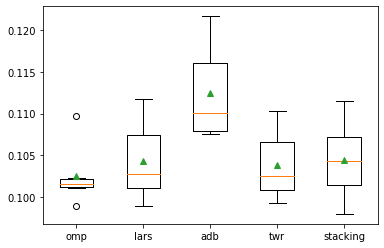

In [239]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import (LinearRegression, Ridge, ElasticNet, OrthogonalMatchingPursuit, BayesianRidge, 
                                  SGDRegressor,Lasso, Lars, LassoLars, TweedieRegressor, BayesianRidge)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor, HistGradientBoostingRegressor
from matplotlib import pyplot
 
X = pd.concat([X_train, X_test], axis=0)
Y = pd.concat([y_train, y_test], axis=0)

# OrthogonalMatchingPursuitCV	-0.0148	-0.0131	0.3403	1.0552	0.0890
# LassoLarsCV	-0.0172	-0.0155	0.3407	1.3803	0.0882
# LarsCV	-0.0172	-0.0155	0.3407	1.4487	0.0882
# ElasticNetCV	-0.0177	-0.0159	0.3408	1.7908	0.0880
# LassoCV	-0.0177	-0.0159	0.3408	1.6675	0.0880
# TweedieRegressor	-0.0210	-0.0192	0.3413	0.3146	0.0824
# GeneralizedLinearRegressor	-0.0210	-0.0192	0.3413	0.2943	0.0824
# AdaBoostRegressor	-0.0268	-0.0251	0.3423	1.7266	0.0818
# Lars	-0.0250	-0.0232	0.3420	0.3285	0.0807

# PoissonRegressor	-0.0206	-0.0189	0.3413	0.4127	0.0805
# OrthogonalMatchingPursuit	-0.0249	-0.0231	0.3420	0.2709	0.0789
# BayesianRidge	-0.0261	-0.0244	0.3422	0.5408	0.0786
# LassoLarsIC	-0.0265	-0.0248	0.3423	0.3870	0.0781
# LinearRegression	-0.0267	-0.0250	0.3423	0.3783	0.0778


# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()

    level0.append(('omp', OrthogonalMatchingPursuit()))
    
    # level0.append(('br', BayesianRidge()))
    
    level0.append(('lars', Lars()))
    
    level0.append(('adb', AdaBoostRegressor()))

    level0.append(('twr', TweedieRegressor()))

    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=3)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()

    models['omp'] = OrthogonalMatchingPursuit()
    
    # models['br'] = BayesianRidge()
    
    models['lars'] = Lars()
    models['adb'] = AdaBoostRegressor()
    models['twr'] = TweedieRegressor()

 
    # models['lars'] = Lars()
	
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=60)
	scores = cross_val_score(model, X, Y, scoring=my_scorer, cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
